<a href="https://colab.research.google.com/github/nick01as/MNIST_GAN/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
import os
import torch
import numpy as np
import pytorch_lightning as L
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

AVAIL_GPU = 1 if torch.cuda.is_available() else 0
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

In [ ]:
class MNISTDataModule(L.LightningDataModule):
  def __init__ (self, data_dir = "./data", batch_size = BATCH_SIZE, num_workers = NUM_WORKERS):
    super().__init__()
    self.root_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    self.transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.1307,), (0.3081,))])
    self.dims = (1,28,28)
    self.num_class = 10

  # Load in MNIST dataset and train/test split
  def prepare_data(self):
    mnist_full = MNIST(self.root_dir, train = True, download = True, transform = self.transform)
    self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    self.mnist_test = MNIST(self.root_dir, train = False, download = True, transform = self.transform)

  # Set up Dataloaders
  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size = self.batch_size, num_workers = self.num_workers)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size = self.batch_size, num_workers = self.num_workers)

  def test_dataLoader(self):
    return DataLoader(self.mnist_test, batch_size = self.batch_size, num_workers = self.num_workers)

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.lin1 = nn.Linear(latent_dim, 7*7*64)
    self.ct1 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 4, stride = 2) # 32 x 16 x 16
    self.ct2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 4, stride = 2) # 16 x 34 x 34
    self.conv = nn.Conv2d(in_channels = 16, out_channels = 1, kernel_size = 7) # 1 x 28 x 28

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = x.view(-1, 64, 7, 7) # Flatten dim 1 and reshape to 64 x 7 x 7

    # 1st Upscale
    x = self.ct1(x)
    x = F.relu(x)

    # 2nd Upscale
    x = self.ct2(x)
    x = F.relu(x)

    # Downscale to 28x28
    return self.conv(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.cv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5)
    self.cv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 5) # Input: 10 x 12 x 12 -> Output: 20 x 8 x 8 -> Dropout: 20 x 8 x 8 -> Max_pool: 20 x 4 x 4
    self.dropout = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 1)

  def forward(self, x):
    x = self.cv1(x) # Input: 1x28x28 -> Output: 10 x 24 x 24
    x = F.max_pool2d(x,2) # Max_pool: 10 x 12 x 12
    x = F.relu(x)

    x = self.cv2(x) # Input: 10 x 12 x 12 -> Output: 20 x 8 x 8
    x = self.dropout(x) # Dropout: 20 x 8 x 8
    x = F.max_pool2d(x,2) # Max_pool: 20 x 4 x 4
    x = F.relu(x)

    # Flatten to 1 x 320
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))

    x = F.dropout(x)
    return F.sigmoid(self.fc2(x))



In [ ]:
class GAN(L.LightningModule):
  def __init__(self, latent_dim = 100, lr = 0.0003):
    super().__init__()
    self.automatic_optimization = False
    self.save_hyperparameters()

    self.generator = Generator(latent_dim = latent_dim)
    self.discriminator = Discriminator()

    self.val_sample = torch.randn(6, latent_dim) # 6 images - each latent_dim = 100

  def forward(self, z):
    return self.generator(z)

  def loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y);

  def configure_optimizers(self):
    opt_g = torch.optim.Adam(self.generator.parameters(), lr = self.hparams.lr)
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr = self.hparams.lr)
    return [opt_g, opt_d]

  def training_step(self, batch):
    real_imgs, _ = batch  # optimized by pl - overrides training_step (which returns batch from DataLoader under the hood)

    opt_g, opt_d = self.optimizers()
    self.toggle_optimizer(opt_g)

    z = torch.randn(real_imgs.size(0), self.hparams.latent_dim).type_as(real_imgs)

    # Optimize Generator: max log(D(G(z))) - maximize number of undetectable fake images
    y_hat = self.discriminator(self.forward(z))
    y = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
    g_loss = self.loss(y_hat, y)

    # Compute g_loss
    self.log("g_loss", g_loss, prog_bar = True)

    # Gradient descent on Generator
    self.manual_backward(g_loss)
    opt_g.step()
    opt_g.zero_grad()
    self.untoggle_optimizer(opt_g)

    # Optimize Discriminator: max log(D(z)) + log(1 - D(G(z))) -- maximize true images detected / minimize false images marked as true
    self.toggle_optimizer(opt_d)

    # max log(D(z))
    y_hat_real = self.discriminator(real_imgs)
    y_real = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)

    # max log(1 - D(G(z)))
    y_hat_fake = self.discriminator(self.forward(z).detach())
    y_fake = torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)

    # Compute d_loss
    d_loss = (self.loss(y_hat_real, y_real) + self.loss(y_hat_fake, y_fake)) / 2

    self.log("d_loss", d_loss, prog_bar = True)

    # Gradient descent on Discriminator
    self.manual_backward(d_loss)
    opt_d.step()
    opt_d.zero_grad()
    self.untoggle_optimizer(opt_d)

  def on_train_epoch_end(self):
    imgs = self.forward(self.val_sample.type_as(self.generator.lin1.weight)).cpu()

    print("Epoch: {}".format(self.current_epoch))
    fig = plt.figure()
    for i in range(imgs.size(0)):
      plt.subplot(2, imgs.size(0)//2, i+1)
      plt.tight_layout()
      plt.imshow(imgs.detach()[i,0,:,:], cmap="gray_r")
      plt.axis("off")
    plt.show()

In [ ]:
model = GAN()
dm = MNISTDataModule()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0


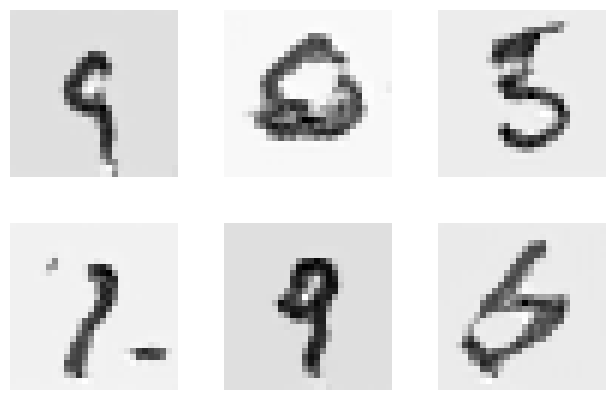

Epoch: 1


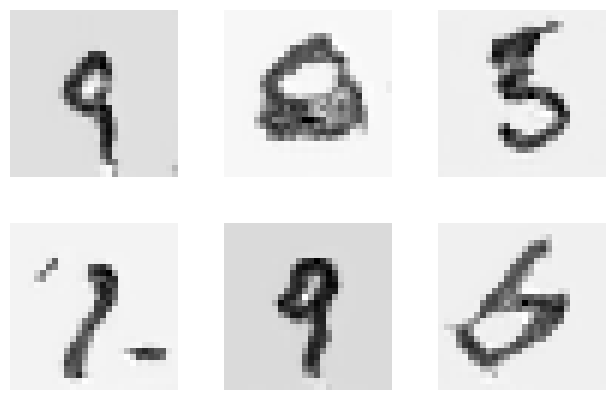

Epoch: 2


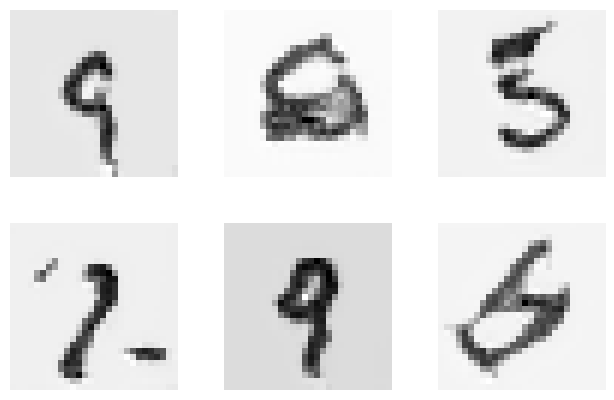

Epoch: 3


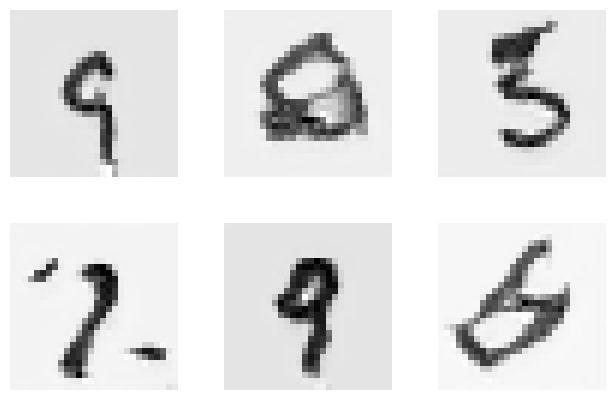

Epoch: 4


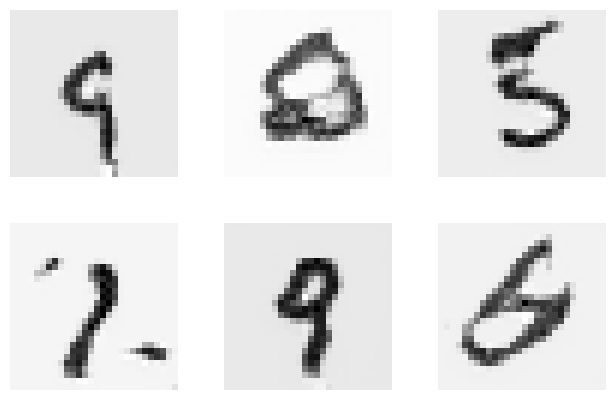

Epoch: 5


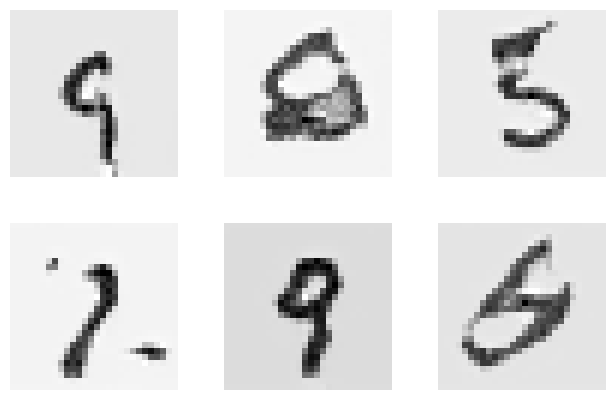

Epoch: 6


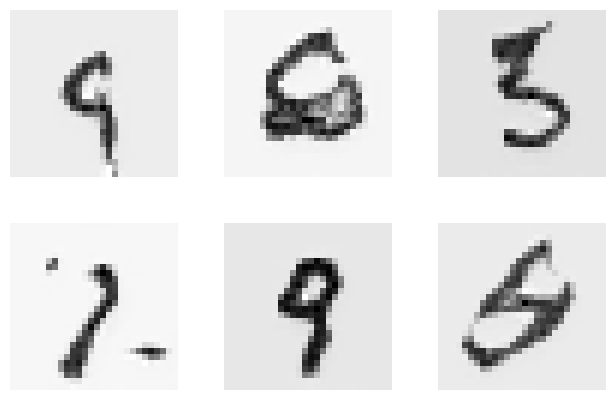

Epoch: 7


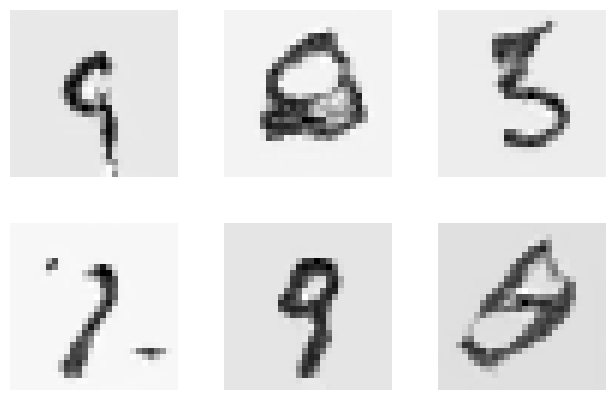

Epoch: 8


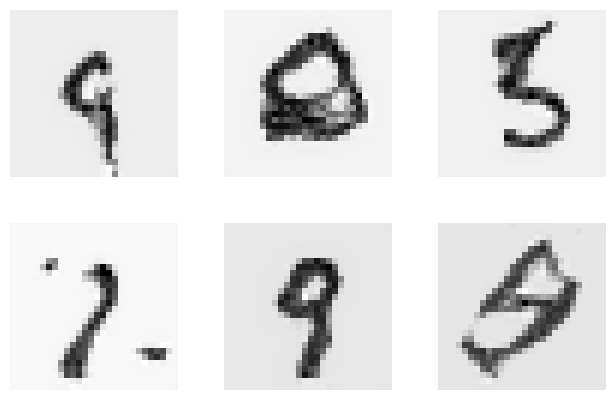

Epoch: 9


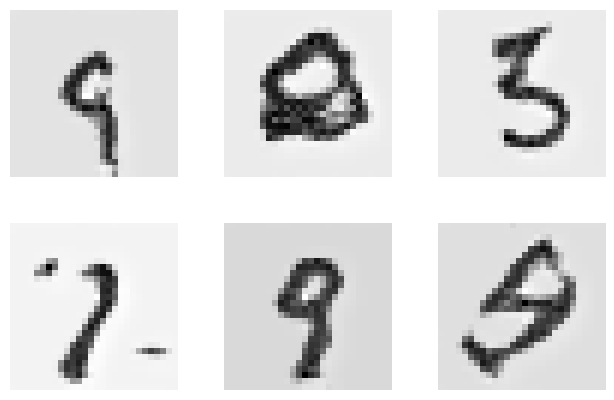

Epoch: 10


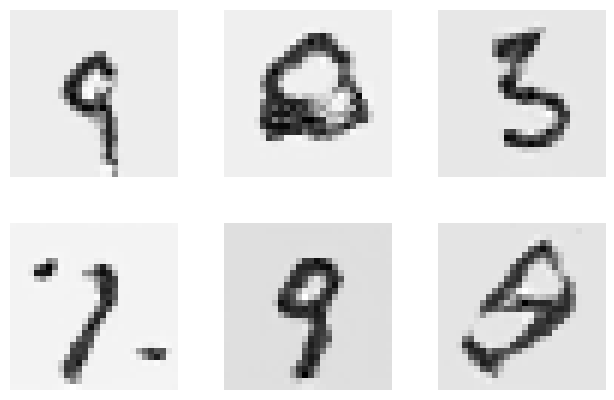

Epoch: 11


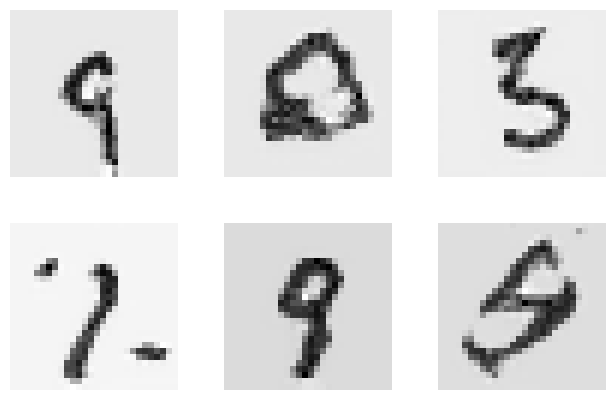

Epoch: 12


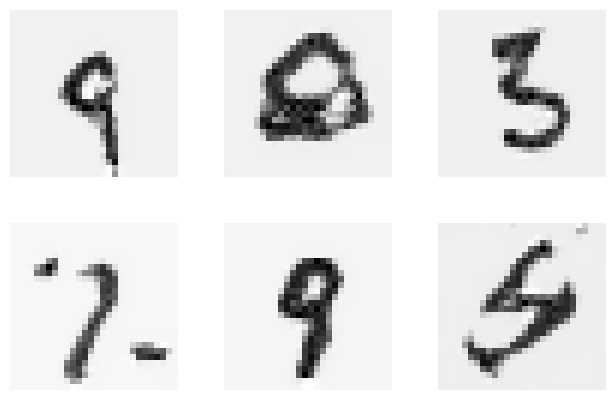

Epoch: 13


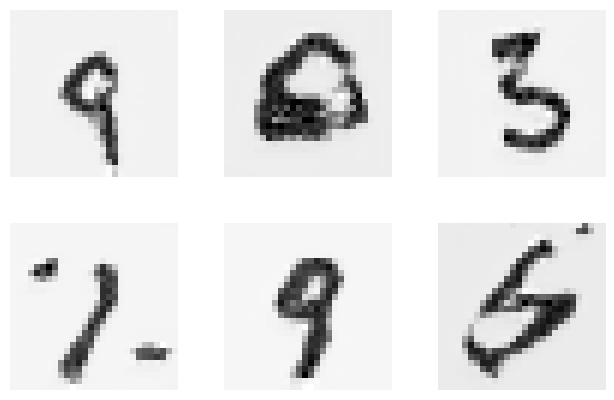

Epoch: 14


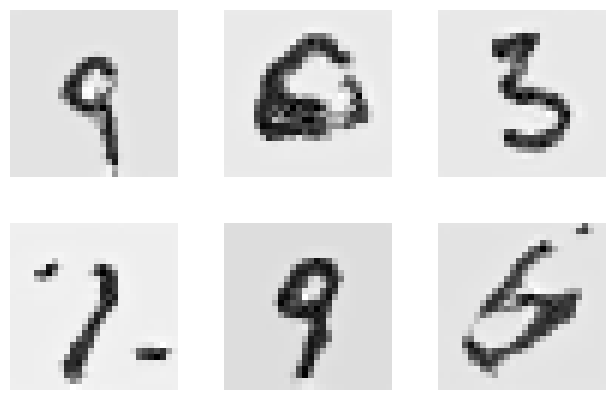

Epoch: 15


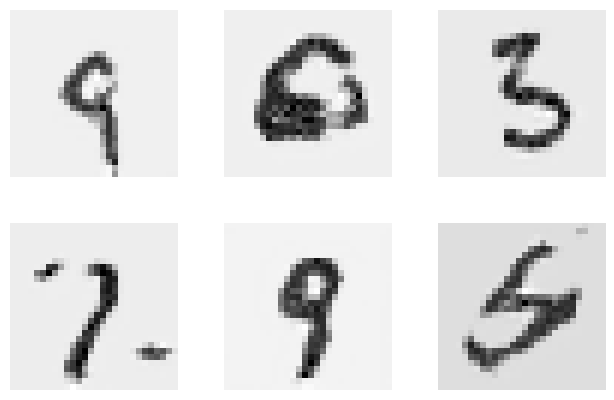

Epoch: 16


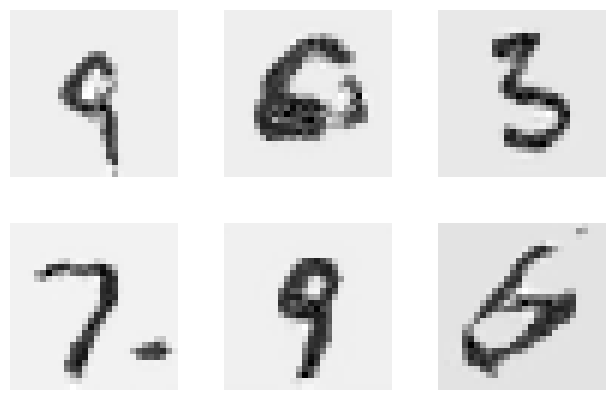

Epoch: 17


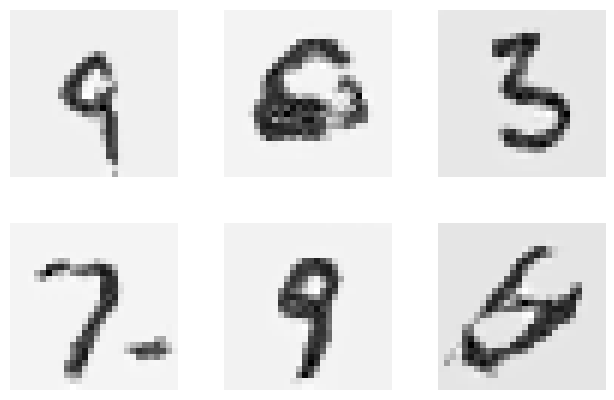

Epoch: 18


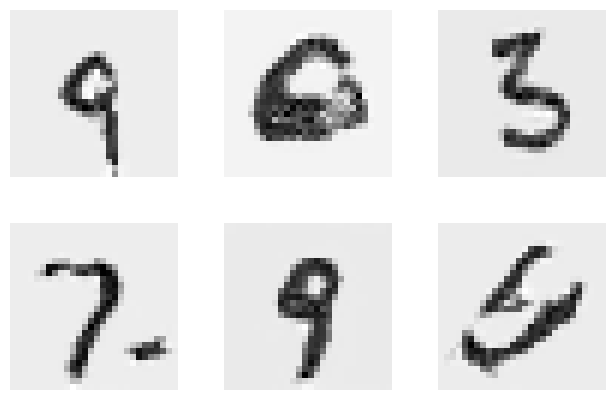

Epoch: 19


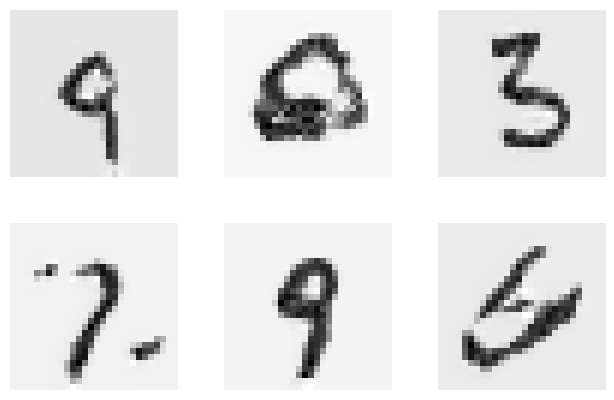

Epoch: 20


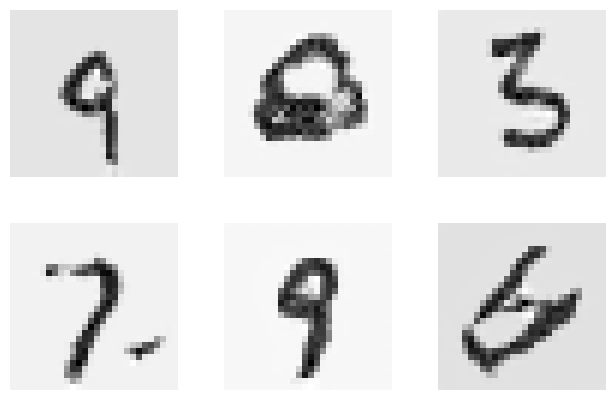

Epoch: 21


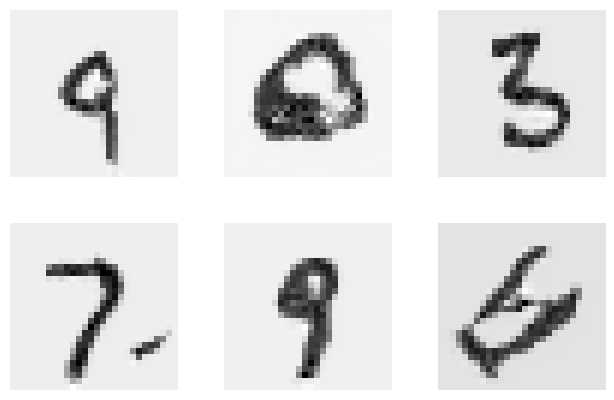

Epoch: 22


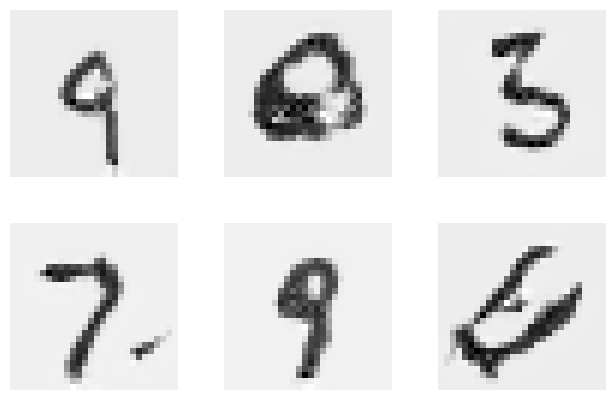

Epoch: 23


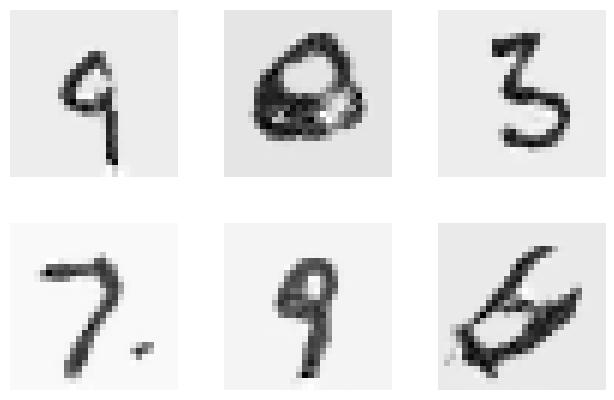

Epoch: 24


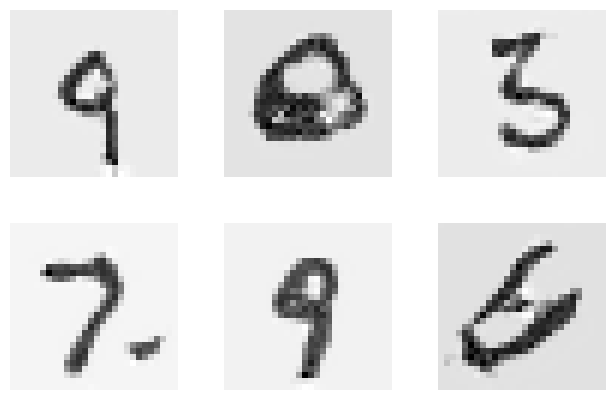

Epoch: 25


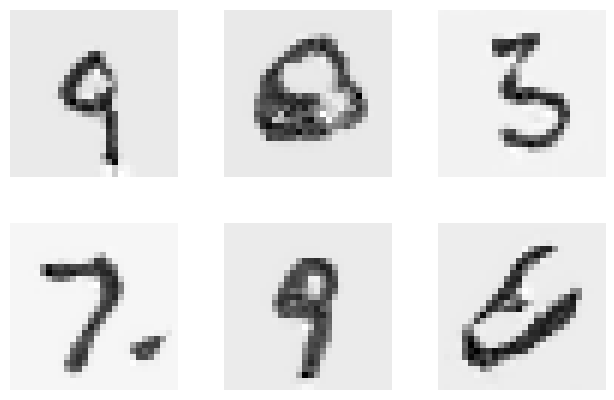

Epoch: 26


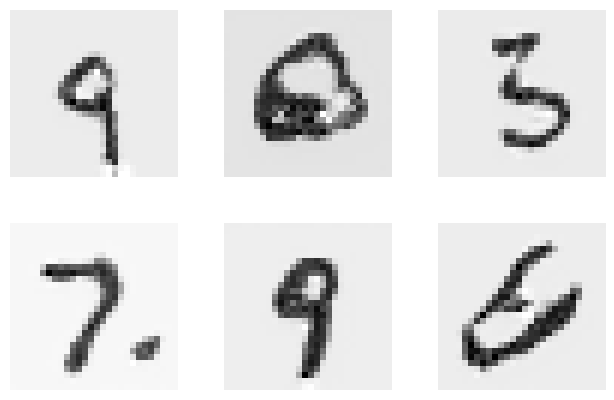

Epoch: 27


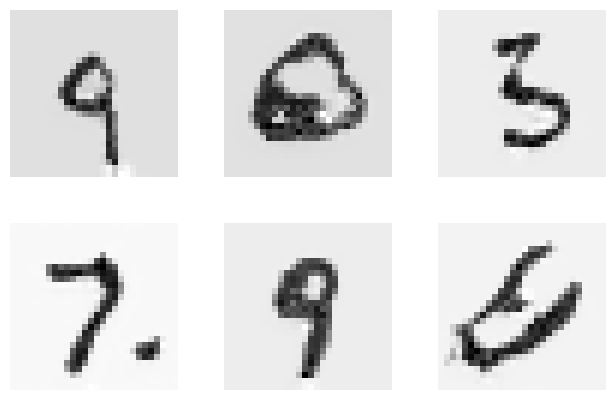

Epoch: 28


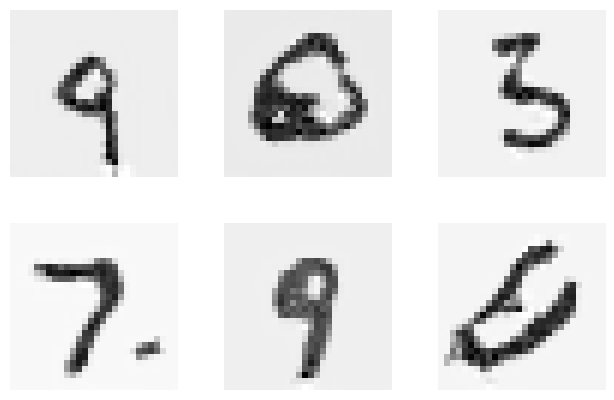

Epoch: 29


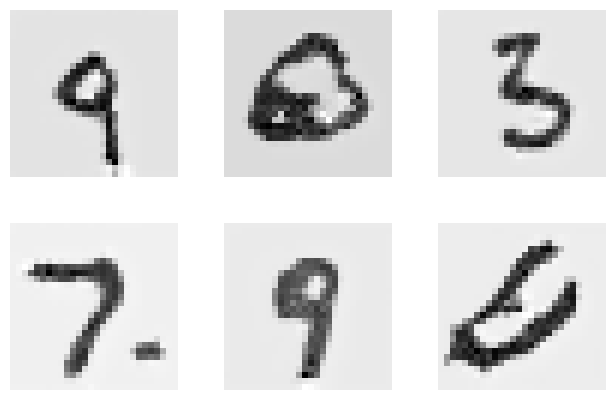

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
trainer = L.Trainer(max_epochs = 30, accelerator = "auto")
trainer.fit(model, dm)

Sample 0


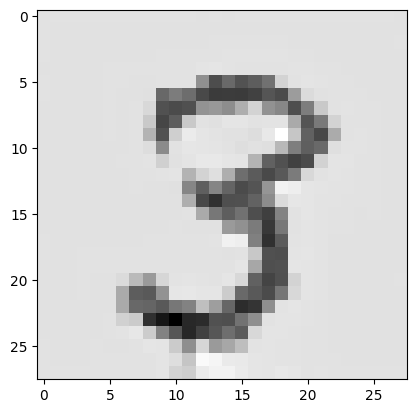

Sample 1


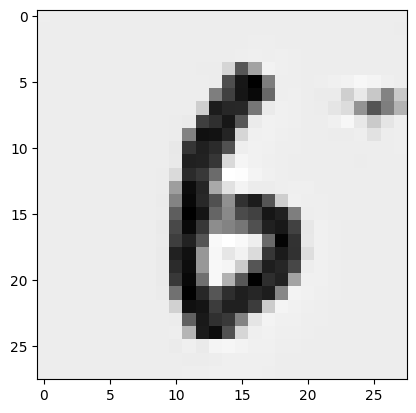

Sample 2


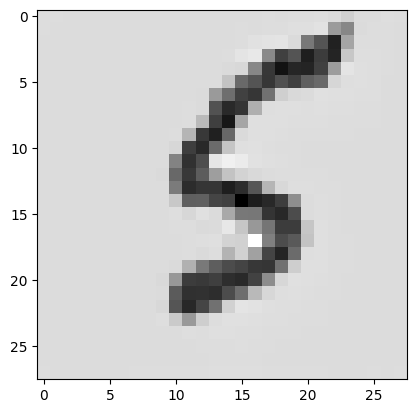

Sample 3


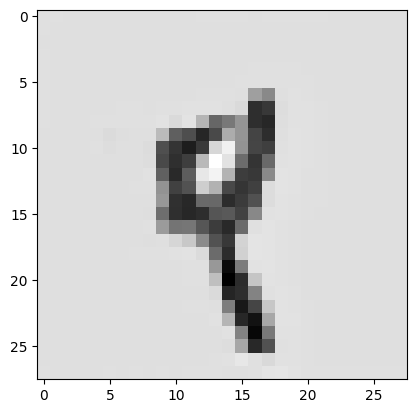

Sample 4


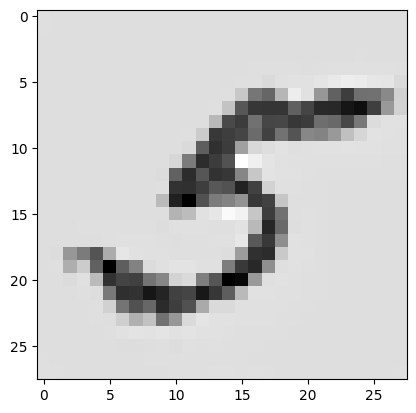

Sample 5


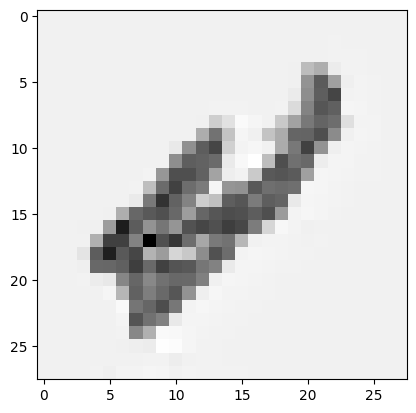

Sample 6


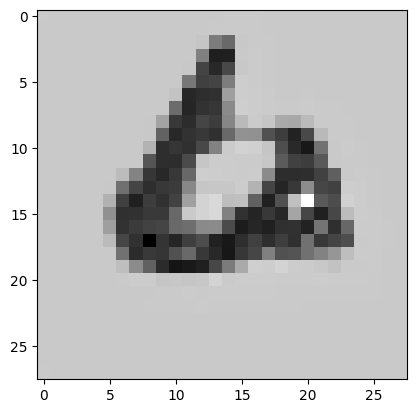

Sample 7


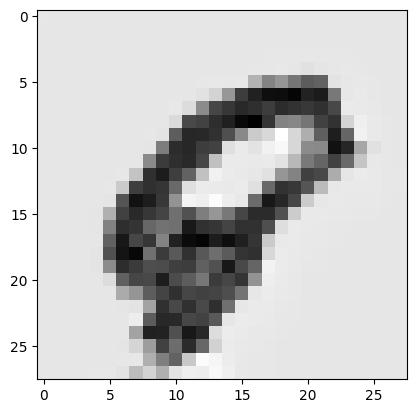

Sample 8


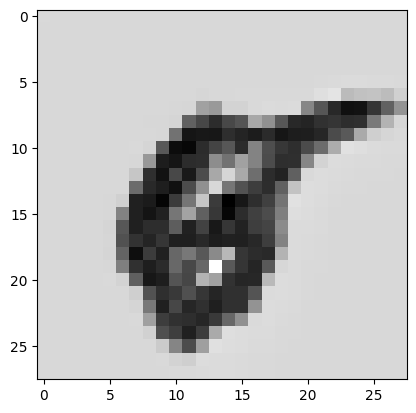

Sample 9


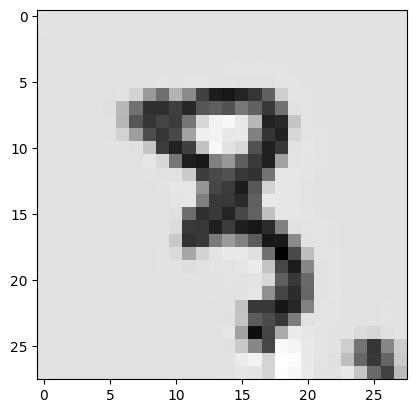

Sample 10


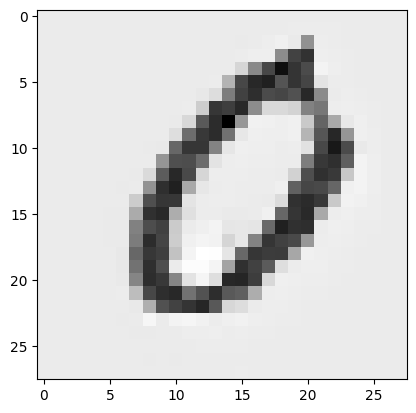

Sample 11


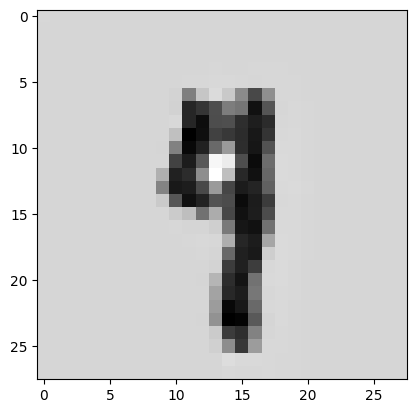

Sample 12


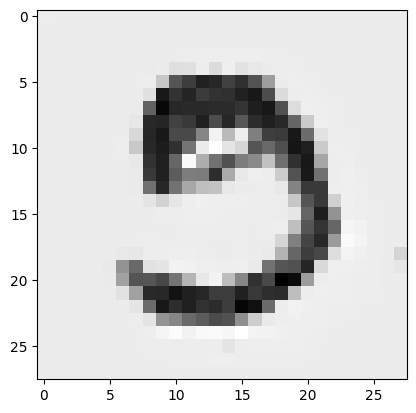

Sample 13


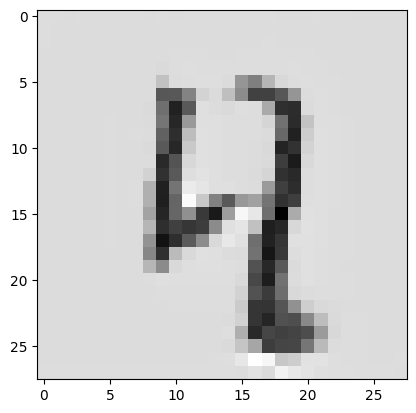

Sample 14


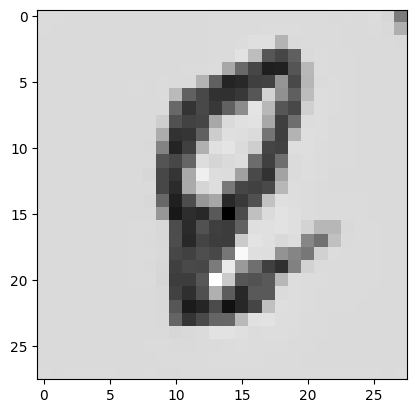

Sample 15


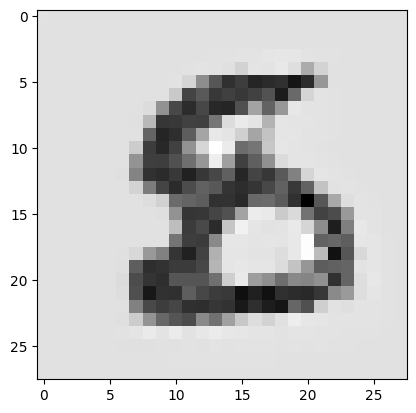

Sample 16


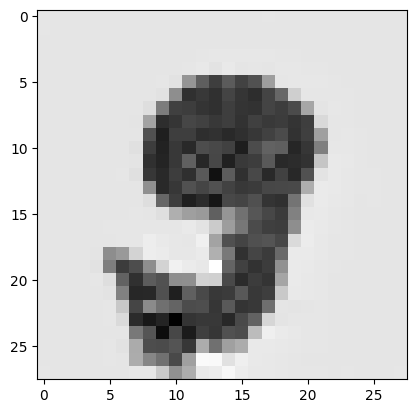

Sample 17


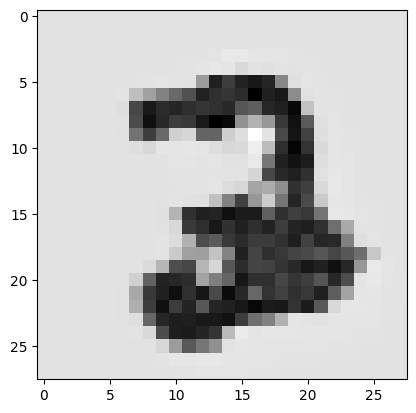

Sample 18


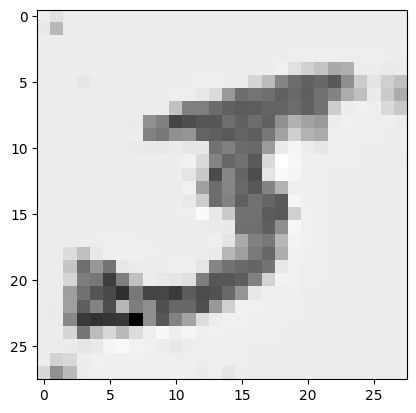

Sample 19


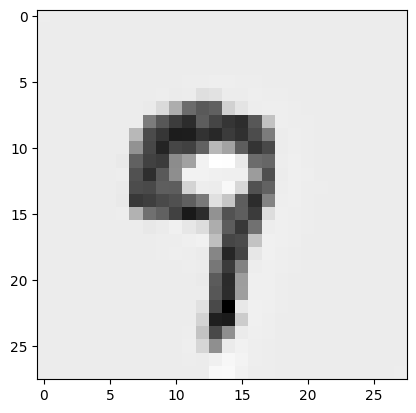

Sample 20


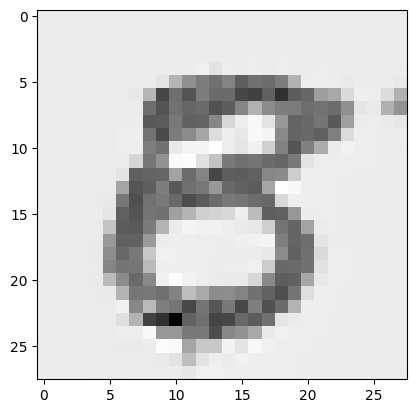

Sample 21


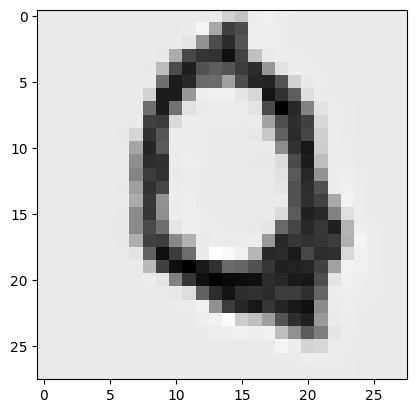

Sample 22


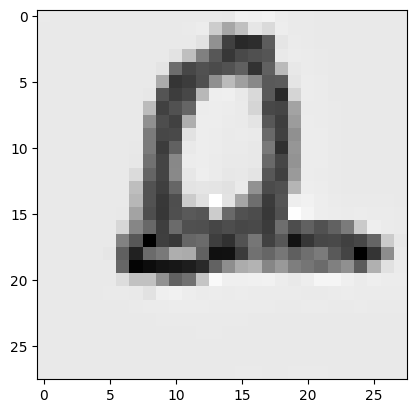

Sample 23


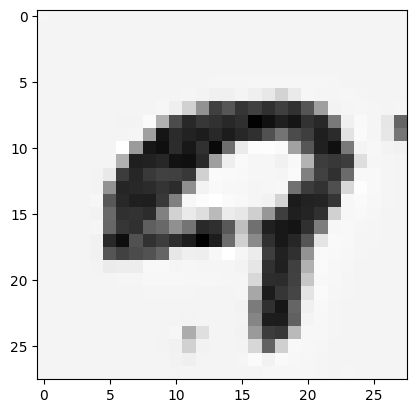

Sample 24


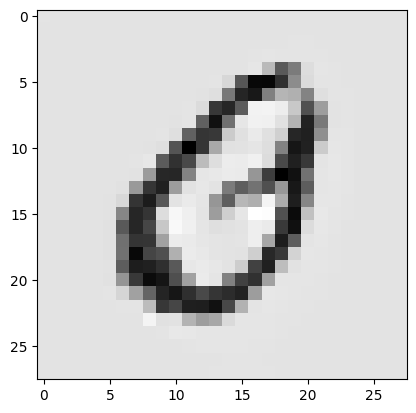

Sample 25


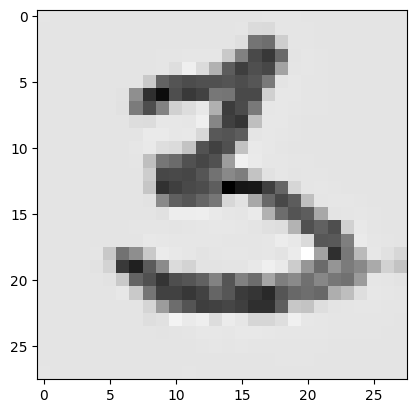

Sample 26


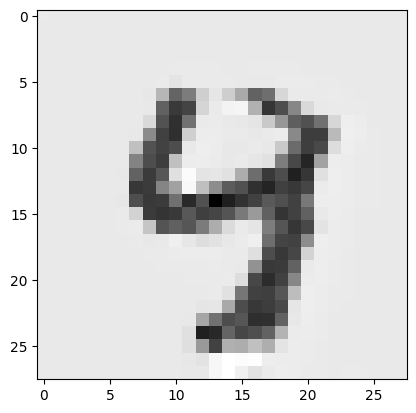

Sample 27


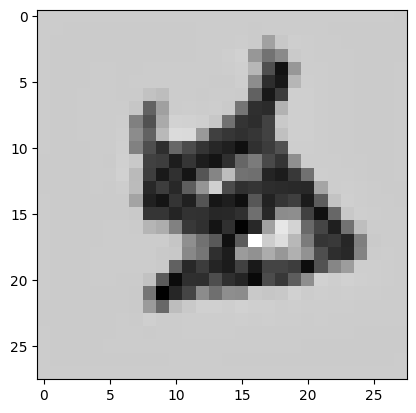

Sample 28


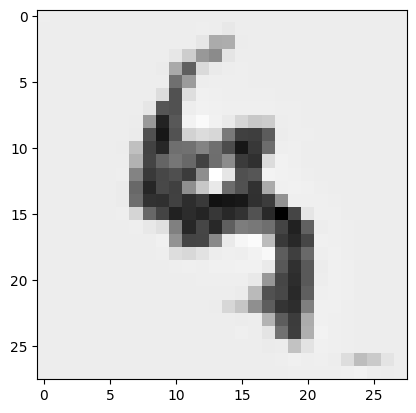

Sample 29


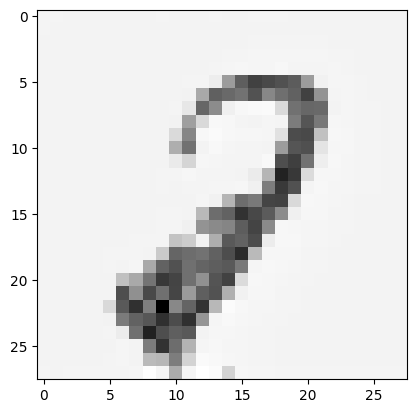

Sample 30


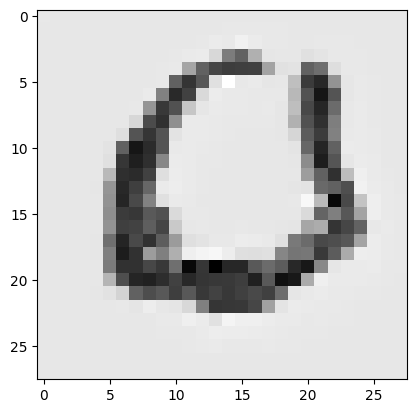

Sample 31


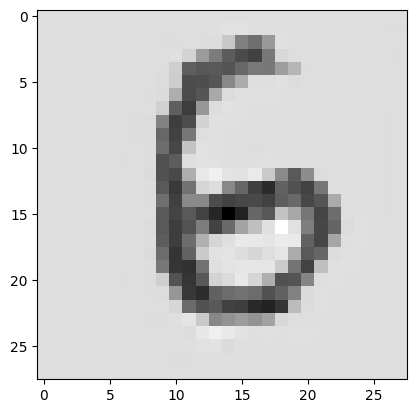

Sample 32


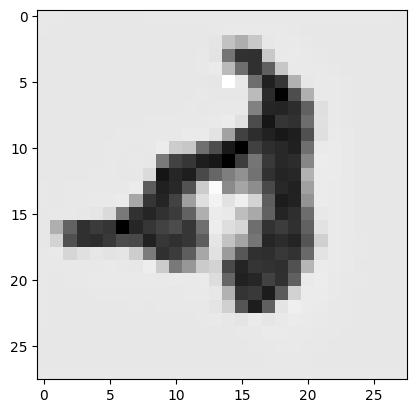

Sample 33


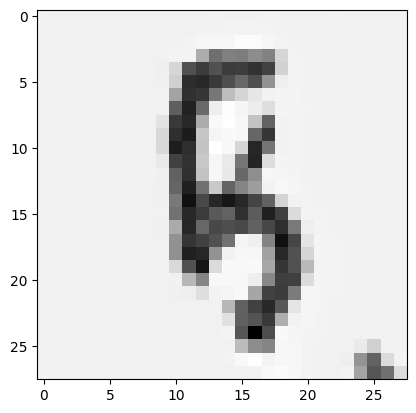

Sample 34


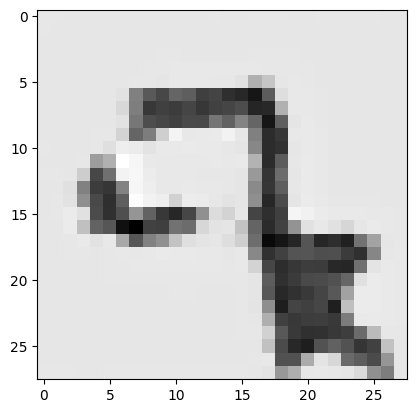

Sample 35


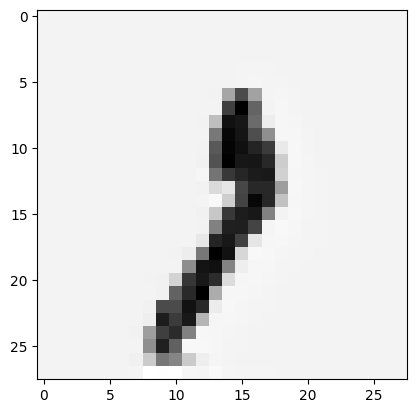

Sample 36


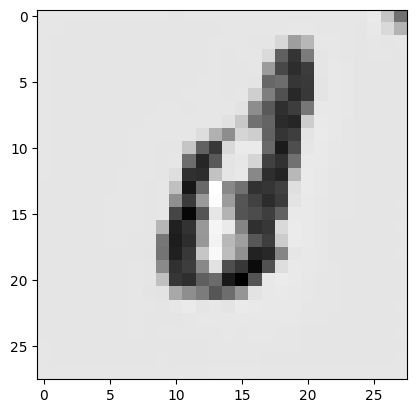

Sample 37


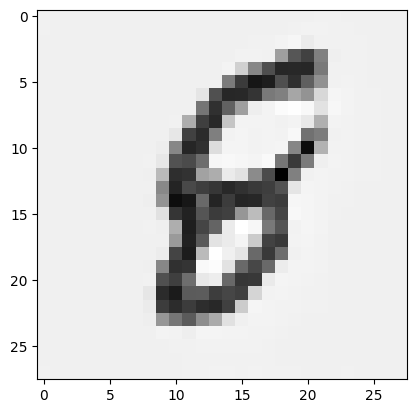

Sample 38


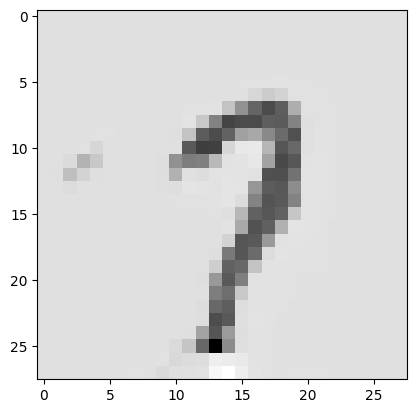

Sample 39


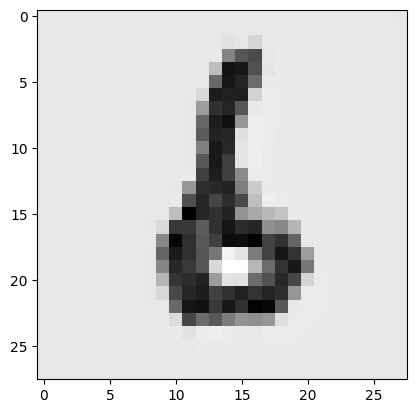

Sample 40


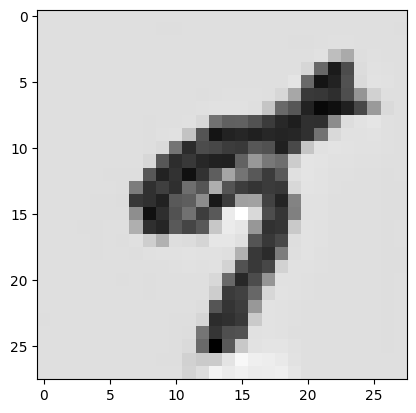

Sample 41


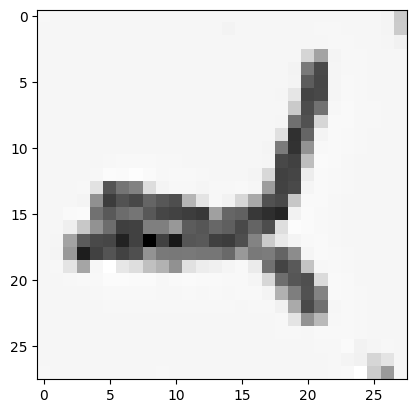

Sample 42


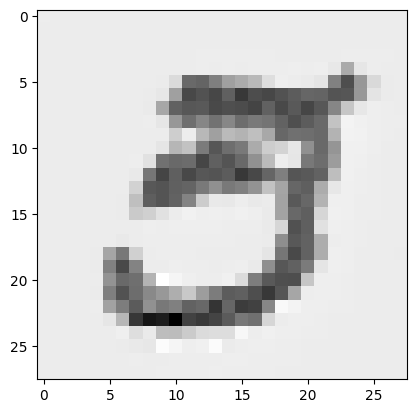

Sample 43


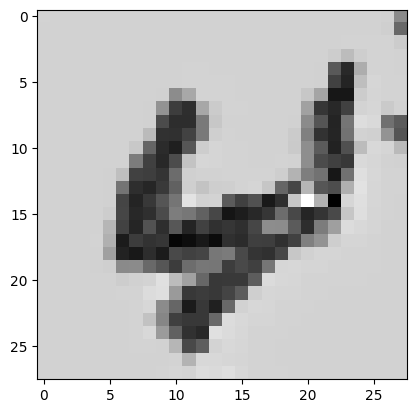

Sample 44


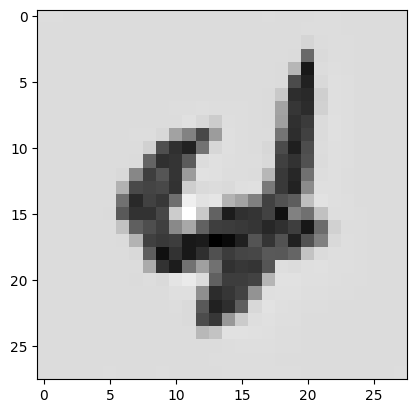

Sample 45


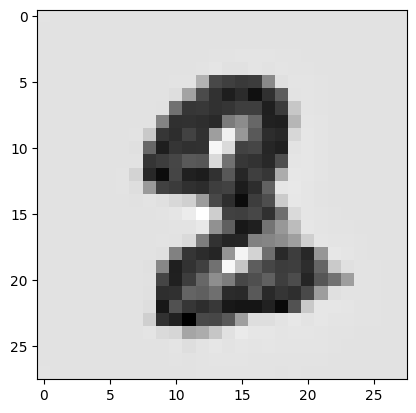

Sample 46


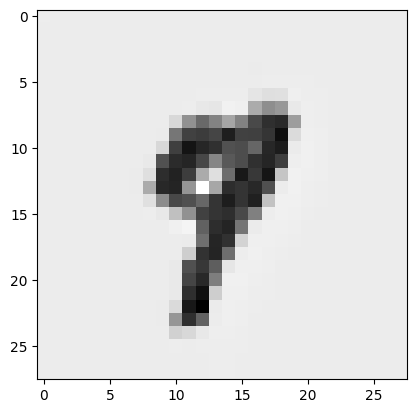

Sample 47


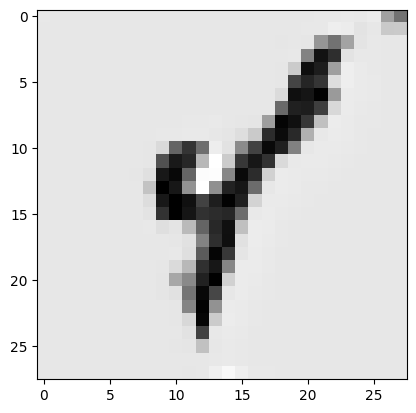

Sample 48


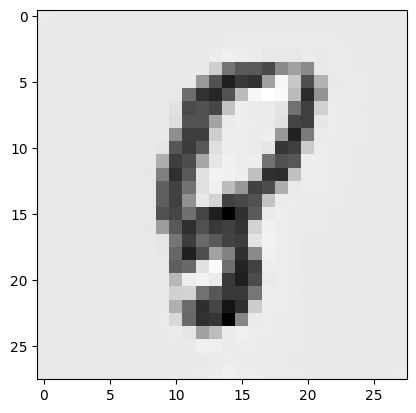

Sample 49


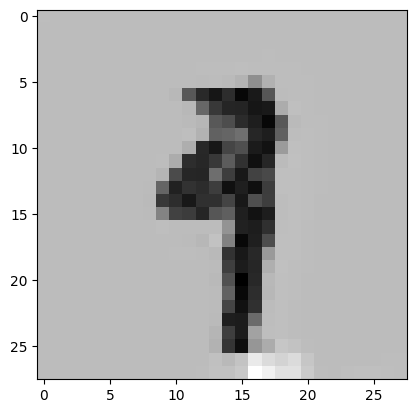

In [ ]:
with torch.no_grad():
  test_sample = torch.randn(50, 100).type_as(model.generator.lin1.weight)
  imgs = model.forward(test_sample)

  for i, img in enumerate(imgs):
    print("Sample {}".format(i))
    plt.imshow(img[0,:,:], cmap='gray_r')
    plt.show()